<a href="https://colab.research.google.com/github/yukliio/Autoencoder-Driven-Model-Based-Transfer/blob/main/nbs/VAE_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is an autoencoder?

In [ ]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import matplotlib.pyplot as plt



In [ ]:
# load the MNIST dataset

mnist_train = torchvision.datasets.MNIST(
    root='./',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

mnist_test = torchvision.datasets.MNIST(
    root='./',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [ ]:
print("Number of training samples:", len(mnist_train))

loader = DataLoader(mnist_train, batch_size=len(mnist_train))
images, ground_truth = next(iter(loader))

Number of training samples: 60000


In [ ]:
images = images.squeeze()  # removes dimensions of size (1)
print(images.shape)
print(ground_truth.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [ ]:
print(torch.min(images[0]))
print(torch.max(images[0]))

images_int = (images * 255).byte()  # convert to 0-255
print(images_int.min(), images_int.max())  # 0 255

tensor(0.)
tensor(1.)
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


tensor(7)


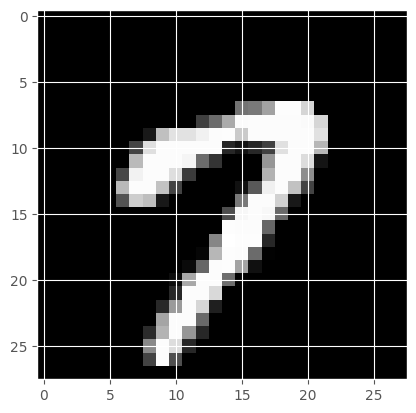

In [ ]:
image_index = 15

print(ground_truth[image_index])
plt.imshow(images[image_index], cmap='gray')

In [ ]:
import torch
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(
    root='./',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)


# stack all images into one tensor
all_images = torch.stack([img for img, label in mnist_train])  # [60000, 1, 28, 28]

# stack all labels into one tensor
all_labels = torch.tensor([label for img, label in mnist_train])  # [60000]

# save to file
torch.save((all_images, all_labels), 'mnist_train.pt')
print("File saved as mnist_train.pt")

File saved as mnist_train.pt


In [ ]:

mnist_test = datasets.MNIST(
    root='./',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)


# stack all images into one tensor
all_images = torch.stack([img for img, label in mnist_test])

# stack all labels into one tensor
all_labels = torch.tensor([label for img, label in mnist_test])

# save to file
torch.save((all_images, all_labels), 'mnist_test.pt')
print("File saved as mnist_test.pt")

File saved as mnist_test.pt


In [ ]:
# map style pytorch dataset

class MNISTDataset(Dataset):
  # need to implement getitem and len methods. creates a map dataste and can query the dataset via index
  def __init__(self, path):
    # loads data into memory
    self.images, self.ground_truth = torch.load(path)

  def __getitem__(self, idx):
    # returns the image with index idx
    x = self.images[idx].float()
    x = torch.flatten(x)
    y = self.ground_truth[idx]

    return x, y

  def __len__(self):
  # returns the length of the dataset
    return len(self.ground_truth)



In [ ]:
# make the dataset
train_dataset = MNISTDataset("mnist_train.pt")
test_dataset = MNISTDataset("mnist_test.pt")

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)



In [ ]:
print(len(train_dataset))
print(len(test_dataset))

60000
60000


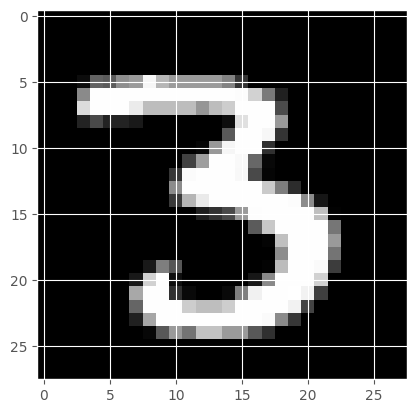

In [ ]:
x, y = train_dataset[12]
plt.imshow(x.numpy().reshape(28,28), cmap='gray')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class AutoEncoder(nn.Module):
  """
  params:
    - input_shape: shape fo the input data
    - latent_dim: size of the latent dim
  """
  def __init__(self, input_shape, latent_dim=128):
    super().__init__()
    # two fully connected layers for encoder (input_shape --> latent dim)
    self.encoder_11 = nn.Linear(in_features=input_shape, out_features=latent_dim)
    self.encoder_12 = nn.Linear(in_features=latent_dim, out_features=latent_dim)

    # two fully connected layers for decder (128 --> input_shape)
    self.decoder_11 = nn.Linear(in_features=latent_dim, out_features=latent_dim)
    self.decoder_12 = nn.Linear(in_features=latent_dim, out_features=input_shape)

  def forward(self, x):
    """
    params:
      - x: input data

    returns:
      - x_hat: reconstructed data
    """

    latent = self.run_encoder(x)
    x_hat = self.run_decoder(latent)
    return x_hat

  def run_encoder(self, x):
    # runs encoder
    output = F.relu(self.encoder_11(x))
    latent = F.relu(self.encoder_12(output))
    return latent

  def run_decoder(self, latent):
    # runs decoder
    output = F.relu(self.decoder_11(latent))
    x_hat = F.relu(self.decoder_12(output))
    return x_hat


In [ ]:
x, y = train_dataset[0]
image_shape = x.shape[0]
print(image_shape)
model = AutoEncoder(input_shape=image_shape)
model.train()
model.cuda()


784


AutoEncoder(
  (encoder_11): Linear(in_features=784, out_features=128, bias=True)
  (encoder_12): Linear(in_features=128, out_features=128, bias=True)
  (decoder_11): Linear(in_features=128, out_features=128, bias=True)
  (decoder_12): Linear(in_features=128, out_features=784, bias=True)
)

In [ ]:
import torch.nn as nn
import torch.optim as optim

mae = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 100

for epoch in range(n_epochs):
    loss = 0
    for batch_features, _ in train_loader:
        batch_features = batch_features.cuda()

        # reset gradients back to zero
        optimizer.zero_grad()


        outputs = model(batch_features)
        train_loss = mae(outputs, batch_features)
        train_loss.backward()
        optimizer.step()

        loss += train_loss.item()

    loss = loss / len(train_loader)

    if epoch % 5 == 0:
        print("epoch: {}/{}, loss = {:.6f}".format(epoch + 1, n_epochs, loss))

# final report
print("epoch: {}/{}, loss = {:.6f}".format(n_epochs, n_epochs, loss))



epoch: 1/100, loss = 0.028639
epoch: 6/100, loss = 0.014197
epoch: 11/100, loss = 0.013376
epoch: 16/100, loss = 0.012935
epoch: 21/100, loss = 0.012675
epoch: 26/100, loss = 0.012546
epoch: 31/100, loss = 0.012486
epoch: 36/100, loss = 0.012436
epoch: 41/100, loss = 0.012397
epoch: 46/100, loss = 0.012357
epoch: 51/100, loss = 0.012330
epoch: 56/100, loss = 0.012302
epoch: 61/100, loss = 0.012290
epoch: 66/100, loss = 0.012281
epoch: 71/100, loss = 0.012238
epoch: 76/100, loss = 0.012225
epoch: 81/100, loss = 0.012214
epoch: 86/100, loss = 0.012194
epoch: 91/100, loss = 0.012186
epoch: 96/100, loss = 0.012174
epoch: 100/100, loss = 0.012160


In [ ]:
model.eval()

AutoEncoder(
  (encoder_11): Linear(in_features=784, out_features=128, bias=True)
  (encoder_12): Linear(in_features=128, out_features=128, bias=True)
  (decoder_11): Linear(in_features=128, out_features=128, bias=True)
  (decoder_12): Linear(in_features=128, out_features=784, bias=True)
)

In [ ]:
kernel_size = 4
init_channels = 8
image_channels = 1
latent_dim =16

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()

        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=64, kernel_size=kernel_size,
            stride=2, padding=0
        )
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        # decoder
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size,
            stride=1, padding=0
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size,
            stride=2, padding=1
        )
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample

    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        hidden = self.fc1(x)
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        z = self.fc2(z)
        z = z.view(-1, 64, 1, 1)

        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var

In [ ]:
import os
os.makedirs("../outputs", exist_ok=True)

In [ ]:
import imageio
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.utils import save_image
to_pil_image = transforms.ToPILImage()
def image_to_vid(images):
    imgs = [np.array(to_pil_image(img)) for img in images]
    imageio.mimsave('../outputs/generated_images.gif', imgs)
def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"../outputs/output{epoch}.jpg")
def save_loss_plot(train_loss, valid_loss):
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(valid_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('../outputs/loss.jpg')
    plt.show()
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD



In [ ]:
def train(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
        counter += 1
        data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss / counter
    return train_loss

def validate(model, dataloader, dataset, device, criterion):
  model.eval()
  running_loss = 0.0
  counter = 0
  with torch.no_grad():
      for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
          counter += 1
          data= data[0]
          data = data.to(device)
          reconstruction, mu, logvar = model(data)
          bce_loss = criterion(reconstruction, data)
          loss = final_loss(bce_loss, mu, logvar)
          running_loss += loss.item()

          # save the last batch input and output of every epoch
          if i == int(len(dataset)/dataloader.batch_size) - 1:
              recon_images = reconstruction
  val_loss = running_loss / counter
  return val_loss, recon_images

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import matplotlib
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
matplotlib.style.use('ggplot')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# initialize the model
model = ConvVAE().to(device)
# set the learning parameters
lr = 0.001
epochs = 100
batch_size = 64
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')
# a list to save all the reconstructed images in PyTorch grid format
grid_images = []


transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
# training set and train data loader
trainset = torchvision.datasets.MNIST(
    root='../input', train=True, download=True, transform=transform
)
trainloader = DataLoader(
    trainset, batch_size=batch_size, shuffle=True
)
# validation set and validation data loader
testset = torchvision.datasets.MNIST(
    root='../input', train=False, download=True, transform=transform
)
testloader = DataLoader(
    testset, batch_size=batch_size, shuffle=False
)

In [ ]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, trainloader, trainset, device, optimizer, criterion
    )
    valid_epoch_loss, recon_images = validate(
        model, testloader, testset, device, criterion
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)
    # convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

Epoch 1 of 100


938it [00:13, 67.07it/s]
157it [00:01, 99.24it/s]                         


Train Loss: 14744.2218
Val Loss: 11363.7844
Epoch 2 of 100


938it [00:14, 65.09it/s]                         
157it [00:01, 95.50it/s]


Train Loss: 11129.6455
Val Loss: 10828.4508
Epoch 3 of 100


938it [00:13, 67.29it/s]                         
157it [00:01, 99.16it/s]                         


Train Loss: 10805.4842
Val Loss: 10676.1088
Epoch 4 of 100


938it [00:13, 67.80it/s]                         
157it [00:01, 99.21it/s]                         


Train Loss: 10652.9855
Val Loss: 10503.7485
Epoch 5 of 100


938it [00:13, 67.14it/s]                         
157it [00:02, 75.97it/s]                         


Train Loss: 10545.3388
Val Loss: 10450.1387
Epoch 6 of 100


938it [00:13, 67.77it/s]                         
157it [00:01, 98.68it/s]                         


Train Loss: 10474.7405
Val Loss: 10380.6490
Epoch 7 of 100


938it [00:13, 68.38it/s]
157it [00:01, 98.42it/s]                         


Train Loss: 10391.4365
Val Loss: 10292.7751
Epoch 8 of 100


938it [00:13, 67.59it/s]                         
157it [00:01, 81.90it/s]                         


Train Loss: 10260.9256
Val Loss: 10118.4801
Epoch 9 of 100


938it [00:14, 66.83it/s]                         
157it [00:01, 100.12it/s]                        


Train Loss: 10153.4863
Val Loss: 10046.6554
Epoch 10 of 100


938it [00:13, 67.55it/s]
157it [00:01, 97.40it/s]                         


Train Loss: 10105.1173
Val Loss: 10038.5681
Epoch 11 of 100


938it [00:13, 67.57it/s]
157it [00:01, 96.78it/s]                         


Train Loss: 10059.0595
Val Loss: 9976.1646
Epoch 12 of 100


938it [00:14, 65.24it/s]
157it [00:01, 96.21it/s]                         


Train Loss: 10030.0394
Val Loss: 9978.5816
Epoch 13 of 100


938it [00:13, 68.26it/s]                         
157it [00:01, 99.52it/s]                         


Train Loss: 10004.2404
Val Loss: 9954.4294
Epoch 14 of 100


938it [00:13, 67.66it/s]                         
157it [00:01, 98.47it/s]                         


Train Loss: 9978.8923
Val Loss: 9935.1939
Epoch 15 of 100


938it [00:13, 67.13it/s]
157it [00:02, 72.40it/s]                         


Train Loss: 9961.1738
Val Loss: 9909.5835
Epoch 16 of 100


938it [00:13, 67.63it/s]                         
157it [00:01, 99.11it/s]                         


Train Loss: 9946.3839
Val Loss: 9947.8771
Epoch 17 of 100


938it [00:13, 68.08it/s]                         
157it [00:01, 99.38it/s]                          


Train Loss: 9930.7502
Val Loss: 9885.7724
Epoch 18 of 100


938it [00:13, 67.31it/s]                         
157it [00:01, 87.74it/s]                         


Train Loss: 9912.7948
Val Loss: 9883.6571
Epoch 19 of 100


938it [00:14, 65.22it/s]                         
157it [00:01, 97.46it/s]                         


Train Loss: 9897.2975
Val Loss: 9870.1355
Epoch 20 of 100


938it [00:13, 67.53it/s]                         
157it [00:01, 97.67it/s]                         


Train Loss: 9888.5814
Val Loss: 9866.6482
Epoch 21 of 100


938it [00:13, 67.84it/s]                         
157it [00:01, 98.93it/s]                         


Train Loss: 9875.0266
Val Loss: 9843.1797
Epoch 22 of 100


938it [00:14, 65.16it/s]                         
157it [00:01, 93.18it/s]                         


Train Loss: 9865.5395
Val Loss: 9822.0330
Epoch 23 of 100


938it [00:13, 68.09it/s]                         
157it [00:01, 98.57it/s]                         


Train Loss: 9853.5900
Val Loss: 9939.0263
Epoch 24 of 100


938it [00:13, 68.01it/s]                         
157it [00:01, 97.58it/s]                         


Train Loss: 9822.8849
Val Loss: 9774.6098
Epoch 25 of 100


938it [00:13, 68.12it/s]                         
157it [00:02, 68.50it/s]                         


Train Loss: 9776.3640
Val Loss: 9724.7097
Epoch 26 of 100


938it [00:13, 67.89it/s]                         
157it [00:01, 98.21it/s] 


Train Loss: 9729.7735
Val Loss: 9705.8859
Epoch 27 of 100


938it [00:13, 67.92it/s]                         
157it [00:01, 98.39it/s]                         


Train Loss: 9708.3297
Val Loss: 9719.2115
Epoch 28 of 100


938it [00:13, 67.88it/s]
157it [00:01, 87.10it/s]                         


Train Loss: 9691.8629
Val Loss: 9661.1462
Epoch 29 of 100


938it [00:14, 66.31it/s]                         
157it [00:01, 100.08it/s]                         


Train Loss: 9680.1730
Val Loss: 9649.4401
Epoch 30 of 100


938it [00:13, 67.74it/s]                         
157it [00:01, 98.66it/s]                         


Train Loss: 9670.9064
Val Loss: 9658.7910
Epoch 31 of 100


938it [00:13, 67.58it/s]                         
157it [00:01, 99.45it/s]                         


Train Loss: 9663.0421
Val Loss: 9654.5492
Epoch 32 of 100


938it [00:14, 66.27it/s]                         
157it [00:01, 83.41it/s]                         


Train Loss: 9654.0268
Val Loss: 9646.6141
Epoch 33 of 100


938it [00:13, 67.76it/s]                         
157it [00:01, 97.20it/s] 


Train Loss: 9643.6965
Val Loss: 9632.3237
Epoch 34 of 100


938it [00:13, 67.89it/s]                         
157it [00:01, 99.97it/s]                          


Train Loss: 9637.2701
Val Loss: 9653.0826
Epoch 35 of 100


938it [00:13, 67.41it/s]
157it [00:02, 70.39it/s]


Train Loss: 9629.1247
Val Loss: 9635.7212
Epoch 36 of 100


938it [00:13, 67.35it/s]                         
157it [00:01, 97.62it/s]                         


Train Loss: 9623.4335
Val Loss: 9617.3515
Epoch 37 of 100


938it [00:13, 67.24it/s]                         
157it [00:01, 99.49it/s]                         


Train Loss: 9615.3487
Val Loss: 9619.2439
Epoch 38 of 100


938it [00:13, 67.21it/s]                         
157it [00:01, 86.53it/s]                         


Train Loss: 9608.8956
Val Loss: 9611.8225
Epoch 39 of 100


938it [00:14, 64.72it/s]                         
157it [00:01, 97.77it/s]                         


Train Loss: 9606.1454
Val Loss: 9618.8427
Epoch 40 of 100


 53%|█████▎    | 496/937 [00:06<00:06, 70.03it/s]